# **Riview Study**

### Objectives
* Evaluate missing data
* Clean data

### Inputs
* General Dataset: outputs/datasets/collection/BreakfastSurvey.csv

### Outputs
* Generate cleaned train and test sets, both under outputs/datasets/cleaned

## Conclusion
- There is no missing data

---

## Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Guest-Survey-Analysis-to-Improve-Hotel-Breakfast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Guest-Survey-Analysis-to-Improve-Hotel-Breakfast'

---

## Load Data

In [4]:
import pandas as pd
df_survey = pd.read_csv("outputs/datasets/collection/BreakfastSurvey.csv")
df_survey.head(3)

,appearance,breakfast,service,staff,variety,price,taste
0,2,No,4,2,2,4,4
1,3,No,4,2,4,4,4
2,1,No,4,2,1,2,2


## Missing Data

In [6]:
vars_with_missing_data = df_survey.columns[df_survey.isna().sum() > 0].to_list()
vars_with_missing_data

[]

There is no missing data

## PPS Analysis

Show PPS matrix

In [9]:
import ppscore as pps

pps_matrix = pps.matrix(df_survey).pivot(columns='x', index='y', values='ppscore')
pps_matrix = pps_matrix.round(2)
pps_matrix

x,appearance,breakfast,price,service,staff,taste,variety
y,,,,,,,
appearance,1.00,0.00,0.77,0.00,0.00,0.75,0.55
breakfast,0.00,1.00,0.00,0.33,0.37,0.00,0.00
price,0.62,0.02,1.00,0.01,0.04,0.92,0.52
service,0.00,0.00,0.00,1.00,0.00,0.00,0.00
staff,0.00,0.02,0.00,0.00,1.00,0.00,0.00
taste,0.60,0.02,0.92,0.01,0.03,1.00,0.54
variety,0.57,0.00,0.57,0.00,0.00,0.58,1.00


Convert the breakfast row to nummerical for Pearson and Spearman

In [10]:
df_corr = df_survey.copy()

df_corr["breakfast"] = df_corr["breakfast"].replace({"Yes, again":2,
                                                     "Yes, next time not":1,
                                                     "No":0
                                                    })

Functions to create Pearson, Spearman and PPS plot

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='magma', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                )
    axes.set_yticklabels(df.columns, rotation=0)
    plt.ylim(len(df.columns), 0)
    plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    mask = np.zeros_like(df, dtype=bool)
    mask[abs(df) < threshold] = True
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                     mask=mask, cmap='inferno', annot_kws={"size": font_annot},
                     linewidth=0.05, linecolor='grey')
    plt.ylim(len(df.columns), 0)
    plt.show()

def DisplayCorrAndPPS(df, corr_type, threshold, figsize=(20, 12), font_annot=8):
    
    print("\n")
    print(corr_type)

    if corr_type=="pps":
        pps_matrix_raw = pps.matrix(df)
        df_corr = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')
        
        pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
        print(pps_score_stats.round(3))
        heatmap_pps(df=df_corr, threshold=threshold, figsize=figsize, font_annot=font_annot)

    elif corr_type=="pearson" or corr_type=="spearman":
        df_corr = df.corr(method=corr_type, numeric_only=True)
        heatmap_corr(df=df_corr, threshold=threshold, figsize=figsize, font_annot=font_annot)
    else:
        print("Invalid type!")

    


Plot Pearson and Spearman correlation



pearson


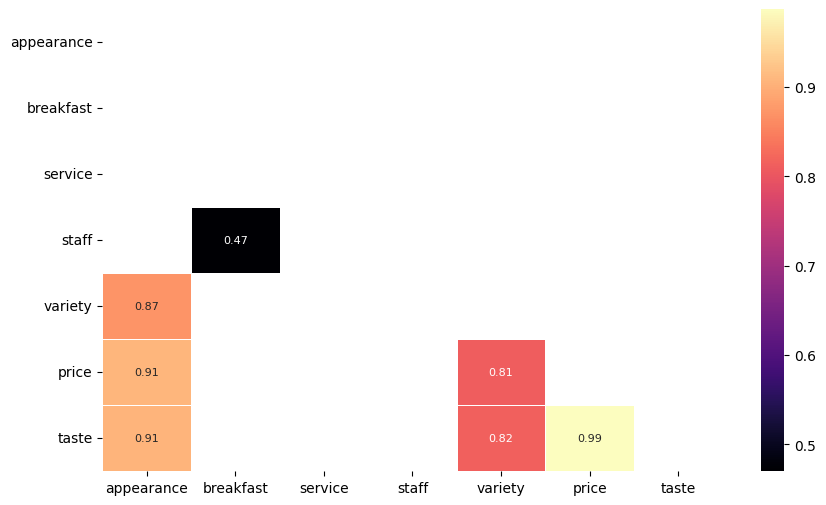



spearman


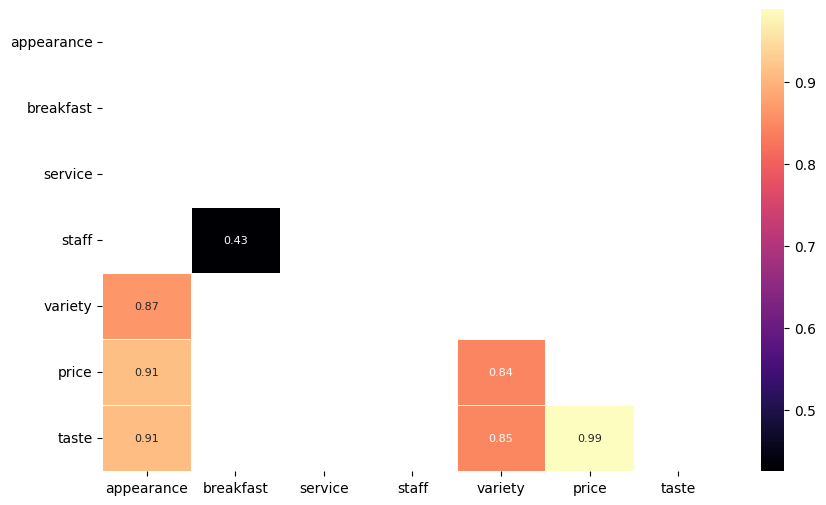

In [12]:
DisplayCorrAndPPS(df=df_corr ,corr_type = "pearson", threshold=0.4, figsize=(10,6))
DisplayCorrAndPPS(df=df_corr ,corr_type = "spearman", threshold=0.4, figsize=(10,6))

- We have to lower the threshold to 0.4 to see the first monotonic and linear correlation between the guest having and the other data. Not a good sign for figuring out how to get more guests to the tables.
- But we may have found another interesting correlation. There are correlations between price and three other data: variety, taste and appearance.

Plot PPS



pps
         count   mean    std  min  25%    50%    75%    max
ppscore   42.0  0.209  0.307  0.0  0.0  0.006  0.532  0.921


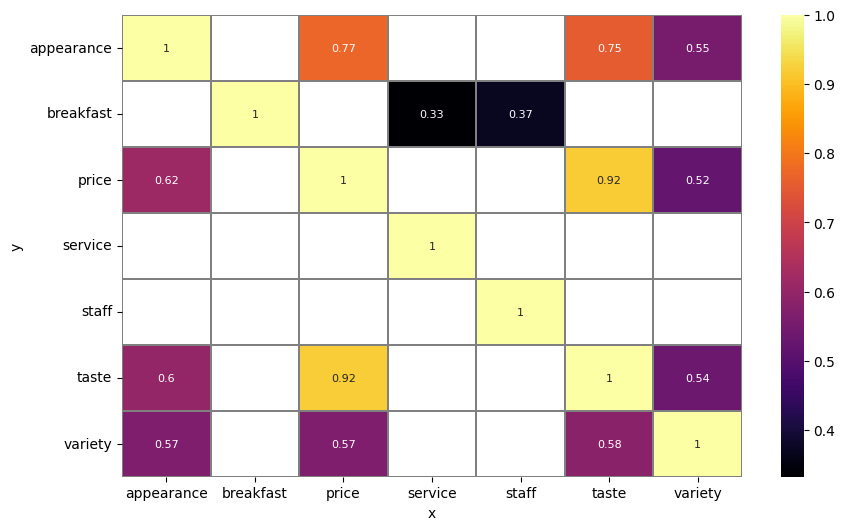

In [13]:
DisplayCorrAndPPS(df=df_survey, corr_type="pps", threshold=0.2, figsize=(10,6))

- The pps table shows that whos have a better opinoin our crew they slitly tend to had breakfast.
- And more interestingly those whose having a better opinion about our those with a very high PPS have a better opinoin about our price as well. And we can see that here as well that the price is correlating with the appearance and the variety variables.

## Split and save train and test set

Create train and test set

In [14]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_survey,
                                        df_survey['breakfast'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (22357, 7) 
TestSet shape: (5590, 7)


Create folder for the train and test set

In [15]:


import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)



[Errno 17] File exists: 'outputs/datasets/cleaned'


Save train set

In [16]:

TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

Save test set

In [17]:

TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)